# How random forests really work.

In [88]:
from fastai.imports import *
np.set_printoptions(linewidth = 110)

In [89]:
train = pd.read_csv('https://raw.githubusercontent.com/DengyiLiu/Deep-Learning-05/main/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/DengyiLiu/Deep-Learning-05/main/test.csv')
tst_df = df_test[['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']].copy()
modes = train.mode().iloc[0]

In [90]:
def proc_data(df):
  df['Fare'] = df.Fare.fillna(0)
  df.fillna(modes, inplace = True)
  df['LogFare'] = np.log1p(df['Fare'])
  df['Embarked'] = pd.Categorical(df.Embarked)
  df['Sex'] = pd.Categorical(df.Sex)

proc_data(train)
proc_data(tst_df)

In [91]:
cats = ['Sex','Embarked']
conts = ['Age','SibSp','Parch','LogFare','Pclass']
dep = ['Survived']

In [92]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [93]:
train.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

In [94]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

# Binary splits

[Text(0.5, 1.0, 'Histogram')]

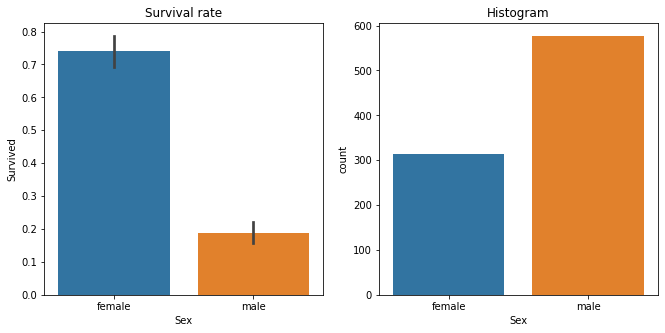

In [95]:
import seaborn as sns

fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=train, y="Survived", x="Sex", ax=axs[0]).set(title='Survival rate')
sns.countplot(data = train, x='Sex', ax=axs[1]).set(title='Histogram')

In [96]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(train, test_size= 0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [97]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs, df.get(dep)

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [98]:
preds = val_xs.Sex==0

In [99]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(preds, val_y)

0.21524663677130046

we can see the error score, it shows that this model is not bad(we just think all femal are survive. If we predict all the male survived, then the score would be high.

In [100]:
preds1 = val_xs.Sex == 1

In [101]:
preds1.count()

223

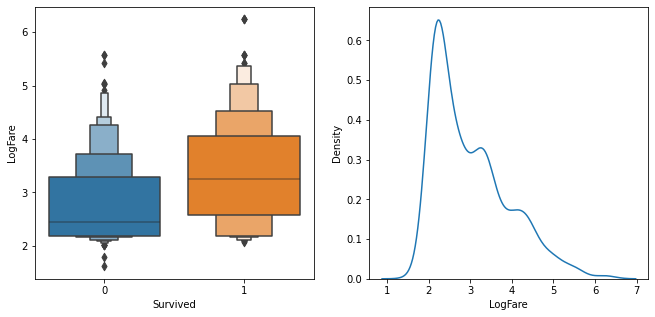

In [102]:
df_fare = trn_df[trn_df.LogFare>0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x='Survived', y='LogFare', ax=axs[0])
sns.kdeplot(data=df_fare, x='LogFare', ax=axs[1])

In [103]:
preds = val_xs.LogFare>3

In [104]:
mean_absolute_error(val_y, preds)

0.3094170403587444

We want the distribution of the split become similiar, we can define a function to calculate the split score.

In [105]:
def _side_score(side, y):
  tot = side.sum() #the number of 
  if tot<=1: return 0
  return y[side].std()*tot

In [106]:
def score(col, y, split):
  lhs = col<=split #left hand side
  return (_side_score(lhs, y) + _side_score(~lhs,y))/len(y)

In [107]:
score(trn_xs['Sex'], trn_y, 0.5)

Survived    0.407875
dtype: float64

In [108]:
score(trn_xs['LogFare'], trn_y, 3)

Survived    0.472029
dtype: float64

The lower the score the better, so sex if better than logfare for split.

Create interact to show the score.

In [109]:
def iscore(nm, split):
  col = trn_xs[nm]
  return score(col, trn_y, split)

from ipywidgets import interact
interact(nm = conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [110]:
interact(nm = cats, split = 2)(iscore)

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

<function __main__.iscore(nm, split)>

How to find the score automatically.

In [111]:
nm = 'Age'
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq# the results of all the possible of binary split.

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  ,
       10.  , 11.  , 12.  , 13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  ,
       23.  , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  , 43.  , 44.  ,
       45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 , 56.  ,
       57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [112]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

In [113]:
def min_col(df, nm):
  col, y = df[nm],df[dep]
  unq = col.dropna().unique()
  scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
  idx = scores.argmin()
  return unq[idx], scores[idx]

min_col(trn_df, 'Age')

(6.0, array([0.47831672]))

In [114]:
cols = cats + conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, array([0.40787531])),
 'Embarked': (0, array([0.47883343])),
 'Age': (6.0, array([0.47831672])),
 'SibSp': (4, array([0.47837403])),
 'Parch': (0, array([0.48052965])),
 'LogFare': (2.4390808375825834, array([0.46208239])),
 'Pclass': (2, array([0.46048262]))}

# Creating a decision tree
How to improve the oneR classifier, which predicts survival based only on sex.  
We can fine the single best split for females and the single best split for males. To do this, all we have to do is repeat the previous section's steps, once for male, and once for females.   
First, remove sex from the list of possible splits and create the two groups:

In [115]:
cols.remove('Sex')
ismale = trn_df.Sex==1

In [116]:
males, females = trn_df[ismale],trn_df[~ismale]

 Now we can find the single best binary split for males:

In [117]:
{o:min_col(males, o) for o in cols}

{'Embarked': (0, array([0.38755819])),
 'Age': (6.0, array([0.37398284])),
 'SibSp': (4, array([0.38758642])),
 'Parch': (0, array([0.38747048])),
 'LogFare': (2.803360380906535, array([0.38048562])),
 'Pclass': (1, array([0.38155442]))}

Females:

In [118]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, array([0.4295253])),
 'Age': (50.0, array([0.42259277])),
 'SibSp': (4, array([0.42319212])),
 'Parch': (3, array([0.41933145])),
 'LogFare': (4.256321678298823, array([0.41350598])),
 'Pclass': (2, array([0.33353889]))}

We can see that the best next binary split for males is Age<=6, and for females if Pclass<=2.
By adding these rules, we have created a decision tree, in these model, first check whether sex is female or male, and depending on the result will then check either the above age or pclass rules, as appropriate. We could then repeat the process, creating new additional rules for each of the four groups we've now created.   
Rather than writing that code manually, we can use DecisionTreeClassifier, from sklearn, which does exactly that for us:

In [132]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

One handy feature or this class is that it provides a function for drawing a tree representing the rules:

In [133]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree{',f'Tree {{size={size}; ratio={ratio}',s))

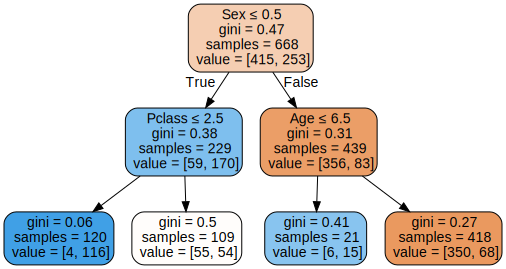

In [134]:
draw_tree(m, trn_xs, size=10)

In [135]:
#gini is also kind of score here is how we can calculate gini.
def gini(cond):
  act = df.loc[cond, dep]
  return 1 - act.mean()**2 - (1-act).mean()**2

In [136]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

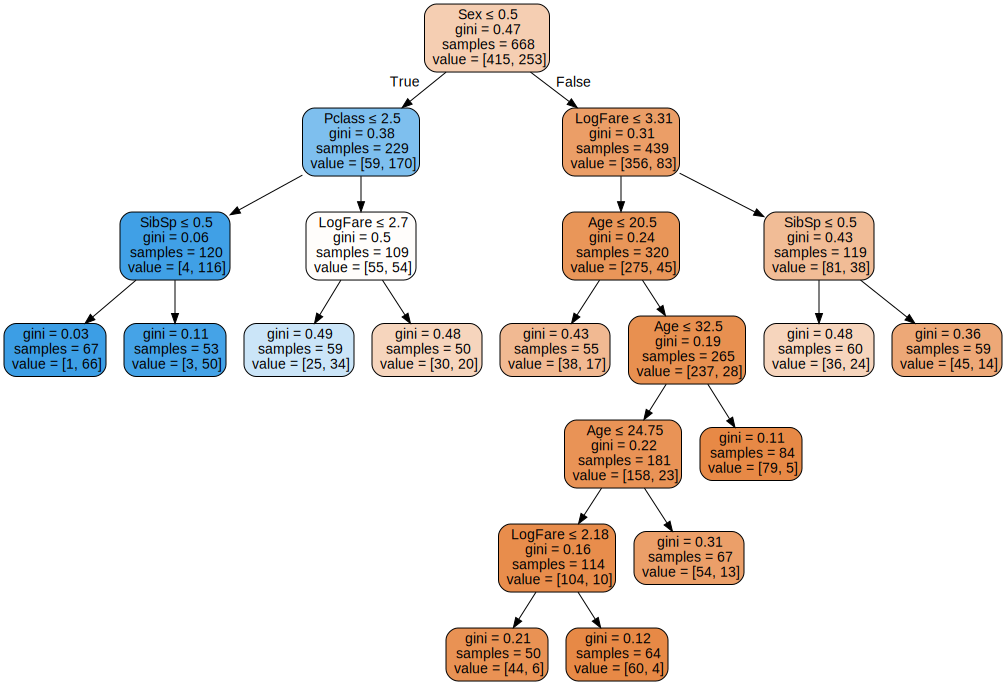

In [138]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [139]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

This model seems better just based on score.

# The random forest

We can't make the decision tree much bigger than the example above, since some leaf nodes already have only 50 rows in them. That's not a lot of data to make a prediction.

So how could we use bigger trees? One big insight came from Leo Breiman: what if we create lots of bigger trees, and take the average of their predictions? Taking the average prediction of a bunch of models in this way is known as bagging.

The idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the predictions, the average will be equal to the true target value -- that's because the average of lots of uncorrelated random errors is zero. That's quite an amazing insight!

One way we can create a bunch of uncorrelated models is to train each of them on a different random subset of the data. Here's how we can create a tree on a random subset of the data:   -- Jeremy Howard.

In [145]:
#a function to create dicision tree
def get_tree(prop=0.75): #75% of the data each time
  n = len(trn_y)
  idxs = random.choice(n, int(n*prop))
  return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

We can create as many trees as we want.

In [146]:
trees = [get_tree() for t in range(100)]

The prediction will be the ave of these trees' predictions.

In [148]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.2267713004484305

Repeat the above process with a random forest.

In [153]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y.values.ravel()) #avoid the warning message
mean_absolute_error(val_y, rf.predict(val_xs))

0.18385650224215247

One particularly nice feature of random forests is they can tell us which independent variables were the most important in the model, using feature-importances_:

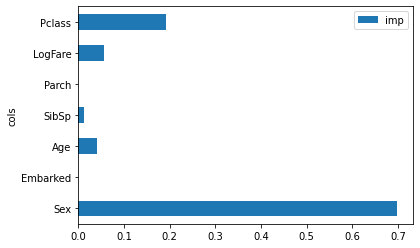

In [154]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols','imp','barh')

,Sex,Embarked,Age,SibSp,Parch,LogFare,Pclass
298,1,2,24.00,0,0,3.449988,1
884,1,2,25.00,0,0,2.085672,3
247,0,2,24.00,0,2,2.740840,2
478,1,2,22.00,0,0,2.142510,3
305,1,2,0.92,1,2,5.027492,1
...,...,...,...,...,...,...,...
106,0,2,21.00,0,0,2.157559,3
270,1,2,24.00,0,0,3.465736,1
860,1,2,41.00,2,0,2.715244,3
435,0,2,14.00,1,2,4.795791,1
